# Fine tuning con LoRA

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import AdamW

from diffusers import AutoencoderKL, UNet2DConditionModel, UNet2DModel

from peft import LoraConfig, get_peft_model

from datetime import datetime

# Carpeta donde guardar
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

def save_lora(unet, name="unet_lora"):
    timestamp = datetime.now().strftime("%m%d_%H%M")
    out_dir = os.path.join(SAVE_DIR, f"{name}_{timestamp}")
    os.makedirs(out_dir, exist_ok=True)
    unet.save_pretrained(out_dir)
    print(f"LoRA guardado en {out_dir}")

def visualize_validation(
    vae,
    unet,
    val_dataset,
    unet_device="cuda",
    vae_device="cpu",
    step_list=[15,30,50],
    num_samples=2,
    color_scale=1.0,
    needs_text=False
):
    indices = np.random.choice(len(val_dataset), num_samples, replace=False)
    fig, axes = plt.subplots(num_samples, len(step_list)+2, figsize=(15, 5*num_samples), squeeze=False)
    
    TEXT_LEN = 77
    TEXT_DIM = 768
    
    for i, idx in enumerate(indices):
        sample = val_dataset[idx]
        # Entrada al VAE en vae_device
        gray = sample["gray"].unsqueeze(0).to(vae_device)
        rgb_img = (sample["rgb"].detach().cpu().permute(1,2,0).numpy()*0.5+0.5).clip(0,1)
        gray_img = (sample["gray"].detach().cpu().permute(1,2,0).numpy()*0.5+0.5).clip(0,1)

        axes[i,0].imshow(gray_img)
        axes[i,0].set_title("Grayscale input")
        axes[i,0].axis("off")

        with torch.no_grad():
            # Codificación con VAE en vae_device
            z_gray_cpu = vae.encode(gray).latent_dist.sample() * 0.18215
            # Mover latente al dispositivo del UNet
            z_gray = z_gray_cpu.to(unet_device)
            
            if needs_text:
                text_zeros = torch.zeros((1, TEXT_LEN, TEXT_DIM), device=unet_device)

            for j, steps in enumerate(step_list):
                z_t = z_gray.clone()
                ts = torch.linspace(1.0, 0.0, steps, device=unet_device)
                for t in ts:
                    t_int = torch.tensor([int(t.item()*999)], device=unet_device)
                    if needs_text:
                        delta_t = unet(sample=z_t, timestep=t_int, encoder_hidden_states=text_zeros).sample
                    else:
                        delta_t = unet(sample=z_t, timestep=t_int).sample
                    z_t = z_t + (1.0/steps) * delta_t

                # Volver al vae_device para decodificar
                z_col_cpu = (z_gray + color_scale * (z_t - z_gray)).to(vae_device)
                out_rgb = vae.decode(z_col_cpu / 0.18215).sample.squeeze(0)
                out_img = (out_rgb.detach().cpu().permute(1,2,0).numpy()*0.5+0.5).clip(0,1)

                axes[i,j+1].imshow(out_img)
                axes[i,j+1].set_title(f"Colorized ({steps} steps)")
                axes[i,j+1].axis("off")

        axes[i,len(step_list)+1].imshow(rgb_img)
        axes[i,len(step_list)+1].set_title("Original RGB")
        axes[i,len(step_list)+1].axis("off")

    plt.tight_layout()
    plt.show()



In [3]:
def train_unet(
    vae,
    unet,
    loader,
    val_dataset,
    opt,
    device="cuda",
    num_epochs=1000,
    epochs_visualization=30,
    needs_text=False
):
    # Stable Diffusion CLIP text dims
    TEXT_LEN = 77
    TEXT_DIM = 768

    unet.train()
    vae.eval()

    scaler = torch.cuda.amp.GradScaler(enabled=(device.startswith("cuda") and torch.cuda.is_available()))

    for epoch in range(num_epochs):
        for batch in loader:
            z_rgb = batch["rgb"].to(device)
            z_gray = batch["gray"].to(device)

            # Mezcla temporal
            t = torch.rand(z_rgb.size(0), device=device)
            z_t = (1 - t.view(-1,1,1,1)) * z_gray + t.view(-1,1,1,1) * z_rgb
            target = z_rgb

            # Timesteps enteros
            t_int = torch.randint(0, 1000, (z_rgb.size(0),), device=device)

            with torch.cuda.amp.autocast(enabled=(device.startswith("cuda") and torch.cuda.is_available())):
                # Llamada al UNet
                if needs_text:
                    text_zeros = torch.zeros((z_rgb.size(0), TEXT_LEN, TEXT_DIM), device=device)
                    delta_hat = unet(sample=z_t, timestep=t_int, encoder_hidden_states=text_zeros).sample
                else:
                    delta_hat = unet(sample=z_t, timestep=t_int).sample

                # Reconstrucción y loss
                recon = z_t + delta_hat
                loss = F.mse_loss(recon, target)

            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

        # Logs parciales
        if (epoch + 1) % max(1, (epochs_visualization // 2)) == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}")

        # Validación cada cierto número de épocas
        if (epoch + 1) % epochs_visualization == 0:
            for cs in [1.2, 1.4, 1.6, 1.8]:
                print(f"color_scale={cs}")
                visualize_validation(
                    vae=vae,
                    unet=unet,
                    val_dataset=val_dataset,
                    unet_device=device, vae_device="cpu",
                    step_list=[2, 15, 50, 100],
                    num_samples=1,
                    color_scale=cs,
                    needs_text=needs_text
                )


## Train

### Load data

In [4]:
# -----------------------------
# Dataset: devuelve pares RGB / Gray
# -----------------------------
class ColorizationDataset(Dataset):
    def __init__(self, img_dir, size=128):
        self.img_dir = img_dir
        self.files = [f for f in os.listdir(img_dir) if f.endswith((".jpg",".png"))]
        self.size = size
        self.to_tensor = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # [-1,1]
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.img_dir, self.files[idx])
        img_rgb = Image.open(path).convert("RGB")
        img_gray = img_rgb.convert("L").convert("RGB")  # 3 canales para VAE

        rgb_tensor = self.to_tensor(img_rgb)   # [3,H,W]
        gray_tensor = self.to_tensor(img_gray) # [3,H,W]

        return {"rgb": rgb_tensor, "gray": gray_tensor}

class LatentDataset(Dataset):
    def __init__(self, latent_file):
        data = torch.load(latent_file)
        self.rgb = data["rgb"]
        self.gray = data["gray"]

    def __len__(self):
        return self.rgb.size(0)

    def __getitem__(self, idx):
        return {"rgb": self.rgb[idx], "gray": self.gray[idx]}


In [5]:
# Dataset original con imágenes
# Limitar a un máximo de imágenes
def generar_latente(max_images = 100, path = None):
    dataset = ColorizationDataset("/kaggle/input/stl10/unlabeled_images", size=128)
    if len(dataset) > max_images:
        dataset.files = dataset.files[:max_images]
    
    loader = DataLoader(dataset, batch_size=16, shuffle=False)
    
    
    vae = AutoencoderKL.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        subfolder="vae"
    ).to("cuda")
    vae.requires_grad_(False)
    
    latents_rgb, latents_gray = [], []
    
    with torch.no_grad():
        for batch in loader:
            rgb = batch["rgb"].to("cuda")
            gray = batch["gray"].to("cuda")
    
            z_rgb = vae.encode(rgb).latent_dist.sample() * 0.18215
            z_gray = vae.encode(gray).latent_dist.sample() * 0.18215
    
            latents_rgb.append(z_rgb.cpu())
            latents_gray.append(z_gray.cpu())
    
    latents_rgb = torch.cat(latents_rgb)
    latents_gray = torch.cat(latents_gray)
    if not path:
        path = f"stl10_latents_{max_images}.pt"
    torch.save({"rgb": latents_rgb, "gray": latents_gray}, path)


## Cargar hiperparámetros

In [6]:
# -----------------------------
# Hiperparámetros
# -----------------------------
NUM_EPOCHS = 10000
EPOCHS_VISUALIZATION = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
LR = 1e-4
SIZE = 128

# -----------------------------
# Modelos: VAE congelado y UNet entrenable
# -----------------------------

vae = AutoencoderKL.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        subfolder="vae"
    ).to("cpu")

## Cargamos modelo y datos

In [7]:
# Cargar SD base
stableDifussion = UNet2DConditionModel.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    subfolder="unet",
    torch_dtype=torch.float16
).to(DEVICE)

# Configuración LoRA
lora_config = LoraConfig(
    r=4,                      # rango de las matrices LoRA
    lora_alpha=16,            # factor de escalado
    target_modules=["to_q", "to_v"],  # capas de atención donde insertar LoRA
    lora_dropout=0.05,
    bias="none",
    task_type="UNET"
)

# Convertir el modelo a LoRA
stableDifussion = get_peft_model(stableDifussion, lora_config)
stableDifussion.print_trainable_parameters()


# -----------------------------
# Dataloader
# -----------------------------
dataset = LatentDataset("stl10_latents_25000.pt")

# Dataset de validación (aún con imágenes, para visualizar resultados)
val_dataset = ColorizationDataset("/kaggle/input/stl10/train_images", size=SIZE)

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# -----------------------------
# Optimizador
# -----------------------------
opt = AdamW(stableDifussion.parameters(), lr=LR, weight_decay=0.01)

In [ ]:
EPOCHS_VISUALIZATION = 2
train_unet(vae, stableDifussion, loader, val_dataset, opt, device=DEVICE, num_epochs=10, needs_text=True)

/tmp/ipykernel_233/1099172403.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.startswith("cuda") and torch.cuda.is_available()))
/tmp/ipykernel_233/1099172403.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.startswith("cuda") and torch.cuda.is_available())):


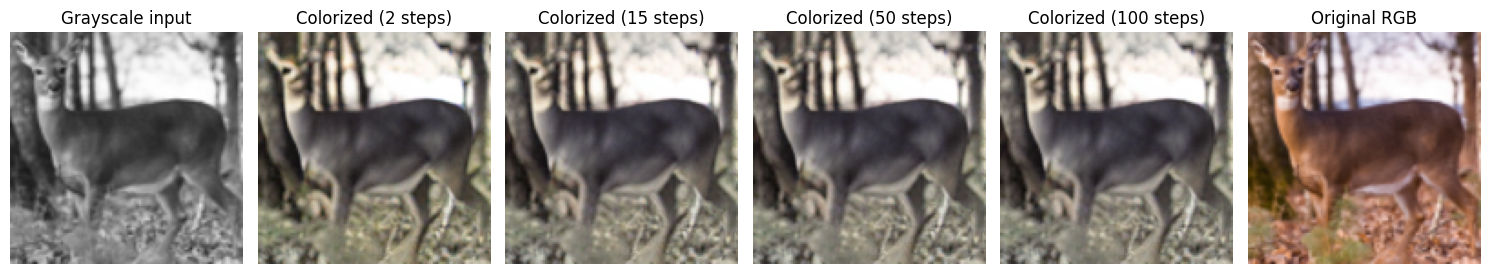

In [17]:
visualize_validation(vae, stableDifussion, val_dataset, unet_device=DEVICE, vae_device="cpu", step_list=[2,15,50,100], num_samples=1, color_scale=1.5, needs_text=True)

## Guardado

In [ ]:
visualize_validation(vae, stableDifussion, val_dataset, device=DEVICE, step_list=[2,15,50,100], num_samples=1, color_scale=1.5)
save_lora(stableDifussion, name=f"unet_lora_epoch{epoch+1}")

## Inferencia

In [ ]:
class Colorizer:
    def __init__(self, vae: AutoencoderKL, unet: UNet2DConditionModel, device='cuda'):
        self.vae = vae.eval().to(device)
        self.unet = unet.eval().to(device)
        self.device = device

    def _preprocess_gray(self, img_gray_pil, size=512):
        img = img_gray_pil.resize((size, size), Image.BICUBIC)
        arr = np.array(img.convert("L").convert("RGB")).astype(np.float32) / 255.0
        arr = (arr - 0.5) / 0.5
        return torch.from_numpy(arr).permute(2,0,1).unsqueeze(0).to(self.device)  # [1,3,H,W]

    def _replace_luma(self, out_rgb_norm, in_gray_norm):
        out = out_rgb_norm.permute(1,2,0).cpu().numpy()*0.5+0.5
        gray = in_gray_norm[0].cpu().numpy()*0.5+0.5
        out_bgr = cv2.cvtColor((out*255).astype(np.uint8), cv2.COLOR_RGB2BGR)
        lab = cv2.cvtColor(out_bgr, cv2.COLOR_BGR2Lab)
        lab[:,:,0] = (gray*255).astype(np.uint8)
        bgr = cv2.cvtColor(lab, cv2.COLOR_Lab2BGR)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        return Image.fromarray(rgb)

    @torch.no_grad()
    def colorize(self, gray_img_pil: Image.Image, steps=50, size=512, color_scale=1.0):
        # 1) Preprocesar y codificar
        gray = self._preprocess_gray(gray_img_pil, size)  # [1,3,H,W]
        z_gray = self.vae.encode(gray).latent_dist.sample() * 0.18215
        z_t = z_gray.clone()

        # 2) Iteración de refinamiento
        ts = torch.linspace(1.0, 0.0, steps, device=self.device)
        for t in ts:
            t_int = torch.tensor([int(t.item()*999)], device=self.device)
            text_emb = torch.zeros((1,77,768), device=self.device)  # dummy text conditioning
            delta_t = self.unet(sample=z_t, timestep=t_int, encoder_hidden_states=text_emb).sample
            z_t = z_t + (1.0/steps) * delta_t

        # 3) Escalado y decodificación
        z_col = z_gray + color_scale * (z_t - z_gray)
        out_rgb = self.vae.decode(z_col / 0.18215).sample.squeeze(0)

        # 4) Reemplazo de luminancia
        final_img = self._replace_luma(out_rgb, gray.squeeze(0))
        return final_img


In [ ]:
import lpips  # pip install lpips
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Cargar VAE y UNet entrenado ---
vae = AutoencoderKL.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    subfolder="vae"
).to(DEVICE)
vae.requires_grad_(False)

unet = UNet2DModel(
    sample_size=16,  
    in_channels=4,
    out_channels=4,
    layers_per_block=2,
    block_out_channels=(128, 256, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D")
).to(DEVICE)

checkpoint = torch.load("checkpoints/unet_epoch500_loss0.0123_20251209_1855.pt", map_location=DEVICE)
unet.load_state_dict(checkpoint["model_state_dict"])
unet.eval()

colorizer = Colorizer(vae, unet, device=DEVICE)

# --- Transformaciones ---
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# --- Métricas ---
lpips_fn = lpips.LPIPS(net='alex').to(DEVICE)

def evaluate_folder(folder_path, num_samples=100):
    psnr_scores, ssim_scores, lpips_scores = [], [], []
    files = os.listdir(folder_path)[:num_samples]

    for fname in files:
        img = Image.open(os.path.join(folder_path, fname)).convert("RGB")
        gray = img.convert("L")

        # Colorizar
        colorized = colorizer.colorize(gray, steps=50, size=256, color_scale=1.0)

        # Convertir a tensores
        img_t = transform(img).unsqueeze(0).to(DEVICE)
        col_t = transform(colorized).unsqueeze(0).to(DEVICE)

        # LPIPS
        lp = lpips_fn(img_t, col_t).item()
        lpips_scores.append(lp)

        # PSNR y SSIM (en CPU con numpy)
        img_np = np.array(img.resize((256,256))).astype(np.float32)
        col_np = np.array(colorized.resize((256,256))).astype(np.float32)

        psnr_scores.append(peak_signal_noise_ratio(img_np, col_np, data_range=255))
        ssim_scores.append(structural_similarity(img_np, col_np, channel_axis=2))

    print(f"LPIPS: {np.mean(lpips_scores):.4f}")
    print(f"PSNR: {np.mean(psnr_scores):.2f}")
    print(f"SSIM: {np.mean(ssim_scores):.4f}")

# --- Ejecutar evaluación ---
evaluate_folder("/kaggle/input/stl10/test_images", num_samples=200)
